# 1. Let's discover our dataset files (assessment and EDA)
We have downloaded 5 files. As a reminder the short description, provided by insideairbnb, is:
the data contains those informations:  

| File name          | File description                                                                |
|--------------------|---------------------------------------------------------------------------------|
| calendar.csv.gz    | Detailed Calendar Data for listings in Paris                                    |
| reviews.csv.gz     | Detailed Review Data for listings in Paris                                      |
| listings.csv.gz    | Detailed Listings data for Paris                                                |
| listings.csv       | Summary information and metrics for listings in Paris (good for visualisations) |
| neighbourhoods.csv | Neighbourhood list for geo filter. Sourced from city or open source GIS files   |

In this notebook, we will:
* load all files sequentially and perform **assessment** + short **Exploratory Data Analysis** phase for each of them
* then try to **relate** them to real **business use cases**

Enough talking, let's load all files and display number of rows and columns for each one.

In [52]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst
from src import visualization as viz
from src import cleaning

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Shape for each file

In [6]:
file_list = datacollector.get_files_list()
for f in file_list:
    compression = 'gzip' if f.endswith(".gz") else 'infer'
    df = pd.read_csv(datacollector.get_data_file(f), sep=',', header=0, compression=compression)
    print("File {} has shape {}".format(f, df.shape))

File listings.csv.gz has shape (64293, 106)
File listings.csv has shape (64293, 16)
File calendar.csv.gz has shape (23467355, 7)
File reviews.csv.gz has shape (1205442, 6)
File neighbourhoods.csv has shape (20, 2)


***Observations:***
* Files `listings.csv` and `listings.csv.gz` are consistent in terms of rows, just the number of columns that changes. As per the files descriptions, the first one is a summary of the second, so this is expected.  
* `calendar` file is the one that contains the most important number of rows (23 million lines !)
* `reviews` file has also a lot of rows, more than one million, few columns.
* `neighbourhoods` file is very small with only 20 rows, which is not a big surprise as per file description.

---
# 1.1. Listings (summary) file
Let's start with the listings file, it is not the first one in the list but the name `listings` seems to be the key element for all other files as well (calendar and reviews are related to listing, as per the description).  
Moreover it is lighter than the complete one (16 columns instead of 106) and the description indicates that it is good for visualization.

In [2]:
df_lst_sum = pd.read_csv(datacollector.get_data_file(cst.LISTING_LIGHT_FILE), sep=',', header=0)
df_lst_sum.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3109,zen and calm,3631,Anne,NaN,Observatoire,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
1,5396,Explore the heart of old Paris,7903,Borzou,NaN,Hôtel-de-Ville,48.85100,2.35869,Entire home/apt,115,1,180,2019-06-21,1.47,1,27
2,7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,2626,Franck,NaN,Hôtel-de-Ville,48.85758,2.35275,Entire home/apt,115,10,248,2019-06-25,2.47,1,240
3,7964,Large & sunny flat with balcony !,22155,Anaïs,NaN,Opéra,48.87464,2.34341,Entire home/apt,130,6,6,2015-09-14,0.05,1,302
4,8522,GREAT FLAT w/ CITY VIEW,25435,Adrien,NaN,Ménilmontant,48.86528,2.39326,Entire home/apt,90,3,1,2010-06-16,0.01,1,186


We have **16** features that describe what is a `listing` and give information about:
* who it belongs to (`host_id` and `host_name`)
* its `name` (some text probably written by the owner) and an `id` (numeric) (probably unique in the Information System)
* its location: some elements about `neighbourhood` (need to dig more this part later) and geographic coordinates `latitude` + `longitude`.
* its type (`room_type`). In this sample all values are the same so perhaps they come from a defined and finite list
* the `price` (numeric)
* `minimum number of nights` to stay I guess
* data about `reviews`: number of reviews for this listing, last time it has been reviewed and a statistic value
* `calculated_host_listings_count`: seems numeric but no real clue so far of what is means
* `availability_365`: I would guess that it means the number of days it is available in a whole year

I will not analyze too deeply this file as I guess that the one that I will really use will be the complete one so I will just perform some quick checks before moving on with another file.

#### Looking for NaN, column types

In [8]:
df_lst_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64293 entries, 0 to 64292
Data columns (total 16 columns):
id                                64293 non-null int64
name                              64224 non-null object
host_id                           64293 non-null int64
host_name                         64229 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     64293 non-null object
latitude                          64293 non-null float64
longitude                         64293 non-null float64
room_type                         64293 non-null object
price                             64293 non-null int64
minimum_nights                    64293 non-null int64
number_of_reviews                 64293 non-null int64
last_review                       49684 non-null object
reviews_per_month                 49684 non-null float64
calculated_host_listings_count    64293 non-null int64
availability_365                  64293 non-null int64
dt

***Observations:***  
There are few missing values in this dataset, only `neighbourhood_group` which has **only missing values** (so what is the purpose of providing this column ? Perhaps it makes sense for some other cities around the world but not this one).  
_Note for later: check in the complete file if it is the same and if yes then we can just drop the column_  
The other columns which contains missing values are the ones about `reviews` (23% missing).

#### Numeric values analysis

In [9]:
df_lst_sum.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,6.429300e+04,6.429300e+04,0.0,64293.000000,64293.000000,64293.000000,64293.000000,64293.000000,49684.000000,64293.000000,64293.000000
mean,1.934634e+07,6.648611e+07,NaN,48.864109,2.345350,116.763925,5.529342,18.749195,1.210193,7.814210,83.641314
std,1.116680e+07,7.693518e+07,NaN,0.018483,0.033776,164.316690,47.874056,38.751261,1.459079,35.337494,118.039870
min,3.109000e+03,2.419000e+03,NaN,48.812890,2.219430,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.186615e+06,1.080773e+07,NaN,48.850670,2.323950,60.000000,2.000000,1.000000,0.230000,1.000000,0.000000
50%,1.968928e+07,3.266216e+07,NaN,48.865260,2.348330,80.000000,2.000000,5.000000,0.700000,1.000000,15.000000
75%,2.950201e+07,9.359166e+07,NaN,48.879230,2.370900,120.000000,4.000000,19.000000,1.640000,1.000000,155.000000
max,3.656124e+07,2.748233e+08,NaN,48.905210,2.471890,9379.000000,9999.000000,809.000000,31.150000,323.000000,365.000000


***Observations:***  
The only relevant statistics to analyze are:
* `price`: listing cost 116 (what is the currency ?) in average with an impressive max value (9379 !)
* `minimum_nights`: the mean is around 5 days (so less than a week) and 50% of the listing have a minimum at 2 so I would say that the "spirit" of the service is respected, we do not have to rent for one week minimum for instance.
* each listing got around 18 `reviews` (mean), some of them have no review (min=0) which explains why we have seen missing values earlier and there is one listing that has more than 800 reviews !
* At least 75% of the people have only one home/apartment to share (probably the one in which they live for the most part of the year). But the max is high as well as the 'mean' and 'standard deviation' values so I guess that there is high variance in the last 25%. In the end, there is no reason for it to be different that everything else in the world: only few people owns the most.
* some of the listing have no `availability` (min=0). Actually, it is even "worse" as 25% of them are not available ! (or maybe at the time the data have been collected it is booked and so not available anymore). 50% of them have few days (~2 weeks) of availability per year while some others are available full year. There is high variance in this feature (as per shown also by the standard deviation value).

With this quick analysis, we can find some "intriguing" values:
* `minimum_nights`: the max is around _27 years_ ! What is this kind of listing ? Is it relevant to keep it in our analysis ?
* max value for the number of `reviews_per_month` for one listing is 31 which means that every day the listing got 1 review. How would that even be possible ? Are there several people who gave a review for the same listing on the same day ? Or is there any cheating here (i.e generating fake reviews) ?
* if my intuition about `calculated_host_listings_count` is right, that would mean that someone has 323 homes/apartments to rent in Paris. Wow, that's impressive, isn't it a business ?

#### Location (neighbourhood, (x,y) coordinates)
`Neighbourhood` seems to be categoric and nominal value, how many different values are there ? 

In [37]:
df_lst_sum.neighbourhood.nunique()

20

There are **20** different values for the neighbourhood. Not so much, later we can use dummy for 1-hot encoding if needed.  
Before going further, let's try to do something with the `latitude` and `longitude` values by plotting them with one different color per neighbourhood. Pay attention to the _palette_ choice as there are quite a lot to draw and if the choice is not appropriate, some colors are recycled which is quite hard to distinguish if they are used to near elements.

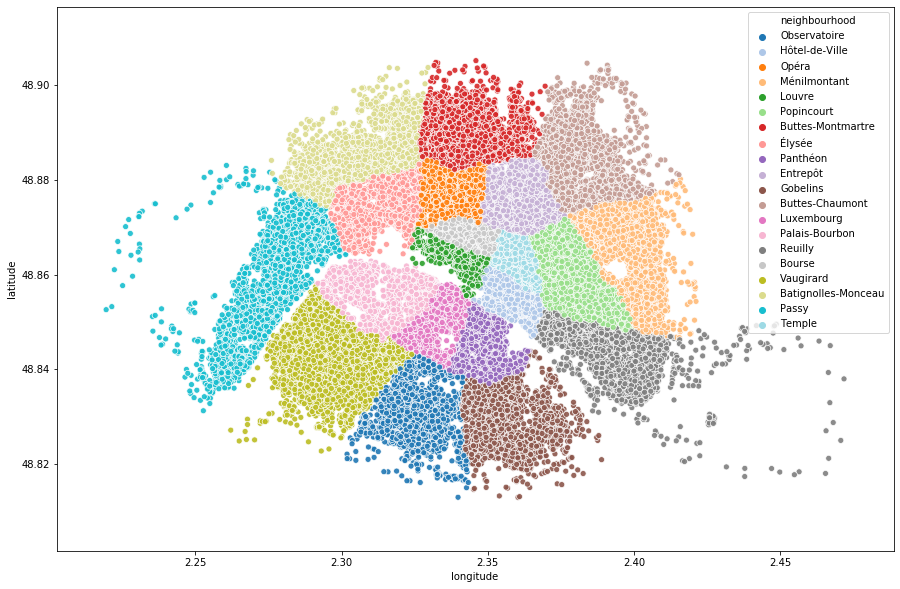

In [3]:
figure, axis = plt.subplots(1, 1, figsize=(15, 10))
sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood", data=df_lst_sum, alpha=0.9, palette="tab20", ax=axis)
plt.show()

Okay ! Here are the 20 neighbourhoods in Paris, they correspond to the 20 districts the city has been splitted in.  
Here is a picture so that you can compare the plot with the reality:
<img src="../assets/paris_neighbourhoods.png" width="550">  
Credits: Pline [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0/)  
We can clearly see why there are no listing in some places in neighbourhoods 12 or 16: it is because there are some woods ("Vincennes", "Boulogne") !  
We are also able to guess the "Seine" which is the river that crosses the city.

---
Let's now take `neighbourhood` as pivot value for further investigations. How many listings are there per neighbourhood ? How available are they ? Is the price really different from one place to another ?
Let's try to analyze that with few plots based on the neighbourhood.

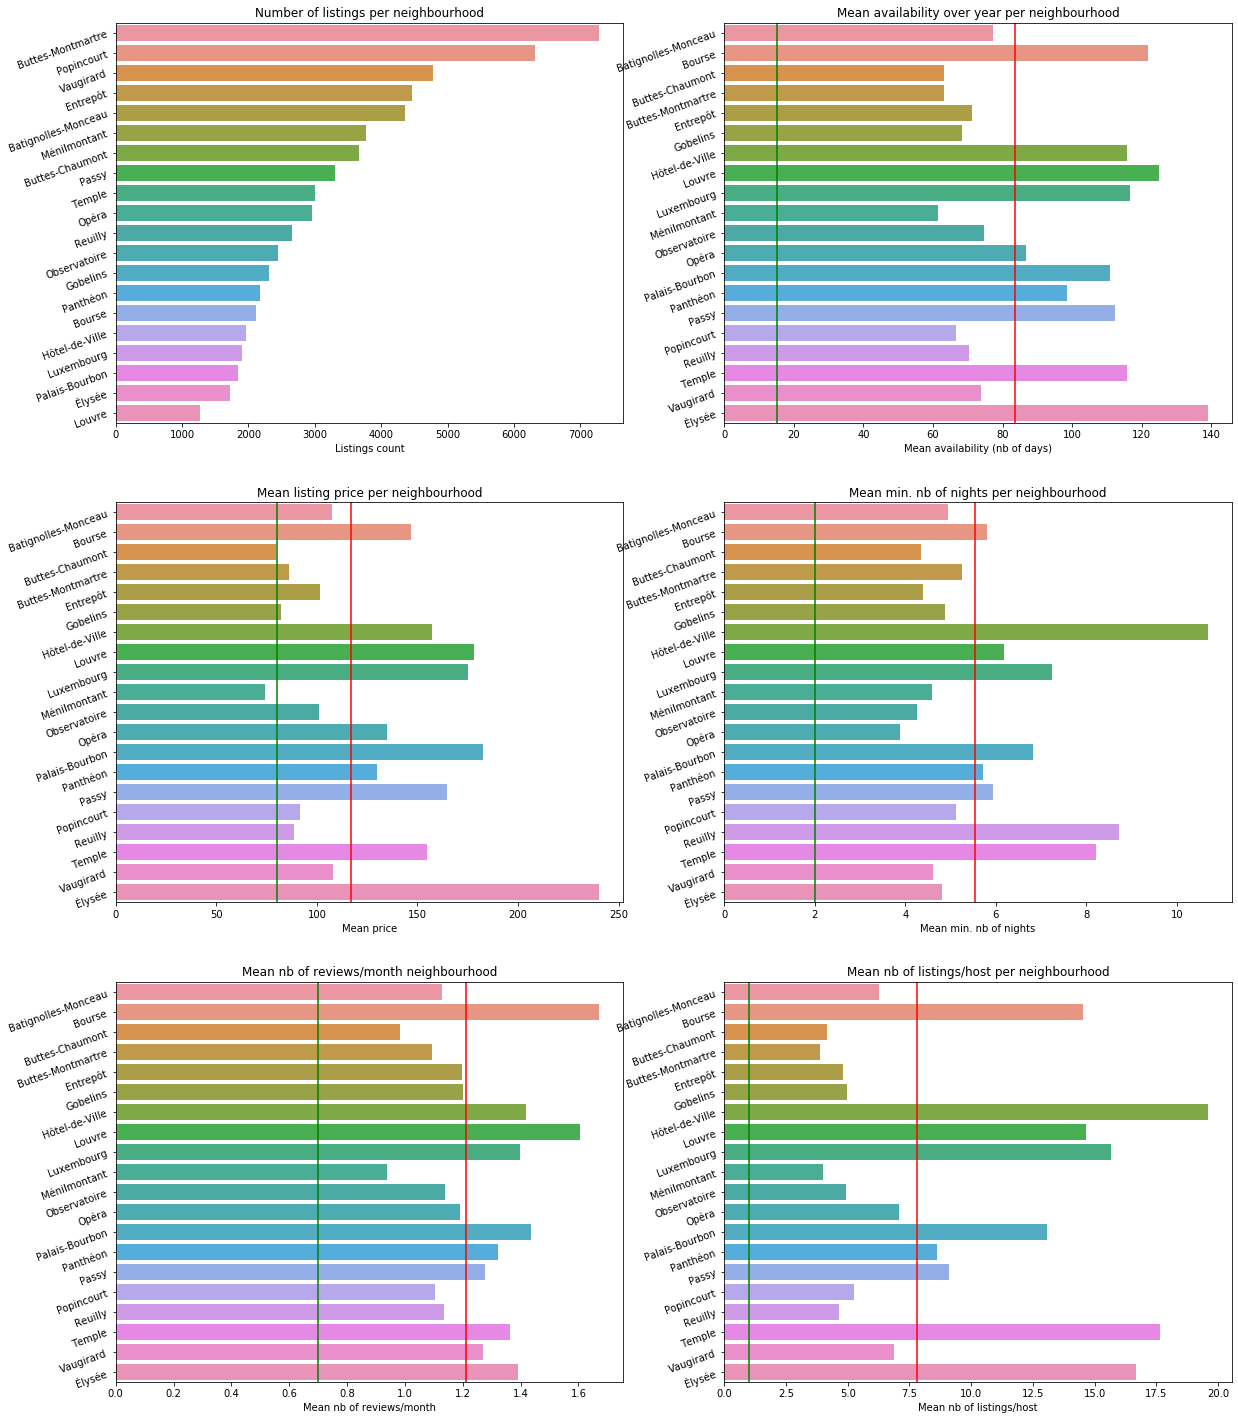

In [22]:
viz.plot_listings_summary_neighbourhood(df_lst_sum)
# Note: in plots below, the green line is for the median, red line is for the mean

***Observations:***
* The **number of listing is unbalanced** and depending on what we will do later, this could be an issue to deal with.
* **_'Elysée'_ is far the more expensive neighbourhood** and the one **with most availability** (perhaps due to the price ?) even if there are few listings (only _'Louvre'_ has less listings to offer).
* 10 neighbourhoods have mean price above the mean value (116, represented by red horizontal line in the last plot) while 10 have mean price below.
* It is though important to notice that only **2 neighbourhoods have mean price below the median value** (80, represented by horizontal green line in last plot): _'Ménilmontant'_ and _'Buttes-Chaumont'_. This is not really a surprise for one who knows Paris are those 2 neighbourhoods are the "less" expensive one. They provide a good number of listings but with few availability per year, 60 days in average.
* There are **3 neighbourhoods** (_'Hotel-de-Ville'_ for example) for which the **minimum number of nights** if you want to stay is **quite high (more than 1 week)**. So if you plan to stay only for few days, some of them are not for you but if you plan to stay longer, it is possible within those neighbourhoods.
* _'Louvre'_ and _'Bourse'_ are the neighbourhoods with the highest number of reviews per month, meaning that if they have a review, it is probably because it has been rented. But this is perhaps not really significant as we have also seen that those 2 neighbourhoods are in the top 3 for availability over a year (even if there are few listings).

---
# 1.2. Calendar file
Next file to analyze is the one named `calendar`.

In [78]:
df_cal = pd.read_csv(datacollector.get_data_file(cst.CALENDAR_FILE), sep=',', header=0)
df_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3109,2019-07-10,f,$75.00,$75.00,3.0,15.0
1,3109,2019-07-11,f,$75.00,$75.00,3.0,15.0
2,3109,2019-07-12,f,$75.00,$75.00,3.0,15.0
3,3109,2019-07-13,f,$75.00,$75.00,3.0,15.0
4,3109,2019-07-14,f,$75.00,$75.00,3.0,15.0


We have **7** features to describe what is a `calendar`:
* `listing_id`: seems to be a reference to listings we have previously seen so I guess we could merge those 2 datasets on this id key.
* `date`: format is yyyy-mm-dd starting from July the 10th. We will see later what will be the max value. Note that this file can then be loaded with _date_parser_ attribute !
* an information about `availability` (we see only 'f' value), we'll see later what are other possible values.
* 2 features for the `price` and `adjusted_price`: values are the same for the first rows. Always the case ? Note that the currency is USD even if french currency is EURO (€).
* `minimum number of nights` and `maximum number of nights` to stay

Some values are numeric but for price for example I would have expect the value to be numeric but the currency is within the value so I will have to clean that by removing the currency symbol.

#### Looking for NaN, column types

In [30]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23467355 entries, 0 to 23467354
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ GB


In [31]:
df_cal.isna().sum()

listing_id          0
date                0
available           0
price             183
adjusted_price    183
minimum_nights     53
maximum_nights     53
dtype: int64

***Observations:***  
There are a lot of rows (more than 23M) and the file is taking a lot of memory once loaded !  
There are very few missing values and we have the same number for both `price` related features or for the `number of nights` so I am pretty sure that when one value is missing in one of those columns it is also missing in the other.  
Let's check if I'm right and what are the listings:

In [40]:
df_cal_na_price = df_cal[df_cal['price'].isna()]
df_cal_na_nights = df_cal[df_cal['minimum_nights'].isna()]
print("Number of missing values for adjusted price is {}".format(df_cal_na_price.adjusted_price.isna().sum()))
print("Listings with missing price are {}".format(df_cal_na_price.listing_id.unique()))
print("Number of missing values for max nights is {}".format(df_cal_na_nights.maximum_nights.isna().sum()))
print("Number of listings with missing info for nights are {}".format(df_cal_na_nights.listing_id.nunique()))

Number of missing values for adjusted price is 183
Listings with missing price are [ 1350971 12997480 13618029 25068274]
Number of missing values for max nights is 53
Number of listings with missing info for nights are 53


Intuition about missing values was right.  
**Only 4 listings have some missing values for the price**, but we have seen in the previous listings file that there were no missing value for `price` so perhaps the value was computed some way. We will have to decide later, depending on what we will do, whether it is important or not.  
There are 53 listings for which we miss 1 information about the nights to stay (min/max).

#### Further investigations

In [44]:
print("Date range: the dataset contains information from {} to {}".format(df_cal.date.min(), df_cal.date.max()))
print("We have {} different listings in the dataset".format(df_cal.listing_id.nunique()))

df_price_diff = df_cal[df_cal['price'] != df_cal['adjusted_price']]
print("{} rows have different values for 'price' and 'adjusted_price'".format(df_price_diff.shape[0]))

Date range: the dataset contains information from 2019-07-09 to 2020-07-10
We have 64293 different listings in the dataset
80701 rows have different values for 'price' and 'adjusted_price'


In [45]:
df_price_diff.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
6746,57766,2019-07-11,t,$650.00,$605.00,6.0,60.0
6747,57766,2019-07-12,f,$650.00,$605.00,6.0,60.0
6748,57766,2019-07-13,f,$650.00,$605.00,6.0,60.0
6749,57766,2019-07-14,f,$650.00,$605.00,6.0,60.0
37965,77482,2019-07-11,f,$600.00,$570.00,2.0,365.0


***Observations***:
* We have 1 year range data(from 09/07/19 to 10/07/20): this is good and explains the number or rows: we have 64293 listings (same shape as the `listings.csv` file) ==> 64293 x 365 = 23466945 which is more or less the number of rows in this dataset. **We have one year of availability information for all listings, 1 row per day**.
* Sometimes, there is a different price which is lower. Seeing the amount it seems to be something like a %discount. For instance, 570 = 95% * 600 (so 5% off).

In [51]:
df_cal.available.value_counts()

f    18037877
t     5429478
Name: available, dtype: int64

There are only 2 possible values: 'f' or 't' so I guess it stands for 'False'/'True'. This will be easily transformed as binary column 0/1.  
Note that there are around 3 times more rows for unavailability than for availability which is correct regarding what we have seen earlier in the `listings` dataset.  

Let's transform both prices columns as numeric to perform some other checks:

In [79]:
# Transformations
df_cal = cleaning.transform_t_f(df_cal, 'available')
df_cal = cleaning.calendar_clean_price(df_cal)

In [80]:
# Control check
df_cal.head(10)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3109,2019-07-10,0,75.0,75.0,3.0,15.0
1,3109,2019-07-11,0,75.0,75.0,3.0,15.0
2,3109,2019-07-12,0,75.0,75.0,3.0,15.0
3,3109,2019-07-13,0,75.0,75.0,3.0,15.0
4,3109,2019-07-14,0,75.0,75.0,3.0,15.0
5,3109,2019-07-15,0,60.0,60.0,3.0,15.0
6,3109,2019-07-16,0,60.0,60.0,3.0,15.0
7,3109,2019-07-17,0,60.0,60.0,3.0,15.0
8,3109,2019-07-18,1,60.0,60.0,3.0,15.0
9,3109,2019-07-19,1,60.0,60.0,3.0,15.0


In [64]:
# Let's check with the first listing_id (3109)
lst_id = 3109
print("There are {} entries for listing {}".format(df_cal[df_cal['listing_id'] == lst_id].shape[0], lst_id))

# Pricing checks
print("Mean price for listing {} is {:.2f}".format(lst_id, df_cal[df_cal['listing_id'] == lst_id].price.mean()))
print("Mean price for listing {} in listings.csv was {}".format(lst_id, df_lst_sum[df_lst_sum['id'] == lst_id].price.mean()))

# Let's try to guess how 'availability_365' (in listings.csv file) is computed 
print("Mean availability for listing {} is {:.2f}".format(lst_id, df_cal[df_cal['listing_id'] == lst_id].available.sum()))
print("Mean availability for listing {} in listings.csv was {}".format(lst_id, df_lst_sum[df_lst_sum['id'] == lst_id].availability_365.mean()))

There are 365 entries for listing 3109
Mean price for listing 3109 is 60.56
Mean price for listing 3109 in listings.csv was 60.0
Mean availability for listing 3109 is 227.00
Mean availability for listing 3109 in listings.csv was 227.0


I think we have now a better understanding of what is this dataset and how it has been used to compute some values (price, availability) we have seen earlier in the previous listings dataset.

Depending on what we will do with the dataset it could be useful to keep the information with details at day level, we will see. Now that features have been transformed to numeric, let's finish this analysis with the well known statistics description.

In [65]:
df_cal.describe()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights
count,2.346736e+07,2.346736e+07,2.346717e+07,2.346717e+07,2.346730e+07,2.346730e+07
mean,1.934623e+07,2.313630e-01,1.217642e+02,1.217566e+02,5.638090e+00,8.505656e+02
std,1.116671e+07,4.217039e-01,1.701814e+02,1.702488e+02,4.794639e+01,3.954738e+04
min,3.109000e+03,0.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
25%,9.186615e+06,0.000000e+00,6.000000e+01,6.000000e+01,2.000000e+00,3.000000e+01
50%,1.968928e+07,0.000000e+00,8.500000e+01,8.500000e+01,3.000000e+00,1.125000e+03
75%,2.950201e+07,0.000000e+00,1.300000e+02,1.300000e+02,4.000000e+00,1.125000e+03
max,3.656124e+07,1.000000e+00,2.500000e+04,2.500000e+04,9.999000e+03,1.000000e+07


***Observations:***  
The only relevant statistics to analyze are:
* `availability`: as already said, less than 25% of the rows have availability=1 (=True)
* `price`: I am really curious to see what are those homes/apartments available with such prices !
* `minimum_nights` and `maximum_nights` have 1 day as the minimum and years (years!) as the maximum (from 27 years to 27000)...Crazy...

---
# 1.3. Reviews file
Let's now analyze the file about `reviews`.

In [66]:
df_reviews = pd.read_csv(datacollector.get_data_file(cst.REVIEWS_FILE), sep=',', header=0)
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3109,123127969,2016-12-27,12389804,Sophie,The host canceled this reservation the day bef...
1,3109,123274144,2016-12-28,67553494,Tom'S,The host canceled this reservation 2 days befo...
2,3109,207127433,2017-10-28,51636494,Patricia,Tout s'est bien déroulé. Merci bien. PG
3,3109,208779822,2017-11-03,4142888,Patricia,Un petit nid fouiller douillet situé dans app...
4,3109,234257457,2018-02-12,3539452,Dominique,The host canceled this reservation 8 days befo...


We have **6** features that describe what is a `review`:
* the `listing`concerned by the review. It is a reference to listings we have previously seen so I guess we could merge those 2 datasets on this id key.
* an `id` (numeric) (probably unique in the Information System)
* the `date` the review has been published/written/posted
* information about the person who wrote the review (its name and id)
* `comments`: what the reviewer said. Note that it seems that sometimes comments are in english (automatic messages ?)

#### Looking for NaN, column types

In [67]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205442 entries, 0 to 1205441
Data columns (total 6 columns):
listing_id       1205442 non-null int64
id               1205442 non-null int64
date             1205442 non-null object
reviewer_id      1205442 non-null int64
reviewer_name    1205442 non-null object
comments         1205101 non-null object
dtypes: int64(3), object(3)
memory usage: 55.2+ MB


In [68]:
df_reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         341
dtype: int64

#### Further investigations

In [73]:
print("Date range: the dataset contains information from {} to {}".format(df_reviews.date.min(), df_reviews.date.max()))
print("We have {} different listings in the dataset".format(df_reviews.listing_id.nunique()))

df_reviews_auto = df_reviews[df_reviews['comments'].str.find('The host canceled this reservation') > -1].id.count()
print("{} rows have an automatic message in 'comments'".format(df_reviews_auto))

lst_id = 3109
# Pricing checks
print("Number of reviews for listing {} is {:.2f}".format(lst_id, df_reviews[df_reviews['listing_id'] == lst_id].id.count()))
print("Number of reviews for listing {} in listings.csv was {}".format(lst_id, df_lst_sum[df_lst_sum['id'] == lst_id].number_of_reviews.mean()))


Date range: the dataset contains information from 2009-06-30 to 2019-07-11
We have 49684 different listings in the dataset
23776 rows have an automatic message in 'comments'
Number of reviews for listing 3109 is 8.00
Number of reviews for listing 3109 in listings.csv was 8.0


***observations:***
* There are 49684 listings with at least one review, which is the same number that we have found earlier when analyzing the `listings` dataset.
* 341 reviews have no comments. Okay but then, what is it about ???

#### What can we do with this file ?
There are few possibilities with this file:
* see who is the **'top' reviewer** (so as well one of the top user of the service !)
* let's assume the reviewer id is unique and shared across whole airnbn, we could try to **analyze where people are going** (wow wow wow, okay we have no information about those people but isn't it borderline with the law regarding personal data ?)
* based on all his comments, try to guess if one reviewer is more likely to give bad or good reviews (would then include some **sentiment analysis**)
* with another indication (note, number of stars, something like that) we could have built a model to perform sentiment analysis and classify reviews. Without any information of this kind I am afraid that we can only do unsupervised learning such as **topic modeling** or something like that.

---
# 1.4. Neighbourhoods file
Let's now analyze the file about `neighbourhoods`.

In [75]:
df_neigh = pd.read_csv(datacollector.get_data_file(cst.NEIGHBOURHOODS_FILE), sep=',', header=0)
df_neigh.head(20)

,neighbourhood_group,neighbourhood
0,NaN,Batignolles-Monceau
1,NaN,Bourse
2,NaN,Buttes-Chaumont
3,NaN,Buttes-Montmartre
4,NaN,Élysée
5,NaN,Entrepôt
6,NaN,Gobelins
7,NaN,Hôtel-de-Ville
8,NaN,Louvre
9,NaN,Luxembourg


This dataset is actually the whole list of `neighbourhoods`. No more. No less. Moreover one column if full of NaN so it will be totally useless for us.

---
# 1.5. Full listing file
Now that we have a better view of all data, let's analyze the full `listings` file.

In [ ]:
df_lst_full = pd.read_csv(datacollector.get_data_file(cst.LISTING_FULL_FILE), sep=',', header=0)
df_lst_full.head()

We have **16** features that describe what is a `listing` and give information about:
* who it belongs to (`host_id` and `host_name`)
* its `name` (some text probably written by the owner) and an `id` (numeric) (probably unique in the Information System)
* its location: some elements about `neighbourhood` (need to dig more this part later) and geographic coordinates `latitude` + `longitude`.
* its type (`room_type`). In this sample all values are the same so perhaps they come from a defined and finite list
* the `price` (numeric)
* `minimum number of nights` to stay I guess
* data about `reviews`: number of reviews for this listing, last time it has been reviewed and a statistic value
* `calculated_host_listings_count`: seems numeric but no real clue so far of what is means
* `availability_365`: I would guess that it means the number of days it is available in a whole year

I will not analyze too deeply this file as I guess that the one that I will really use will be the complete one so I will just perform some quick checks before moving on with another file.

#### Looking for NaN, column types

---
# 3. Business understanding

---
# Listings

In [41]:
df_lst.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


---
## Merging calendar + listings

In [9]:
df_merged = pd.merge(df_cal, df_lsts, how='left', left_on='listing_id', right_on='id')
df_merged.drop('listing_id', axis=1, inplace=True)

In [10]:
df_merged.shape

(23467355, 22)

In [11]:
df_merged.head()

,date,available,price_x,adjusted_price,minimum_nights_x,maximum_nights,id,name,host_id,host_name,...,latitude,longitude,room_type,price_y,minimum_nights_y,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2019-07-10,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
1,2019-07-11,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
2,2019-07-12,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
3,2019-07-13,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
4,2019-07-14,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227


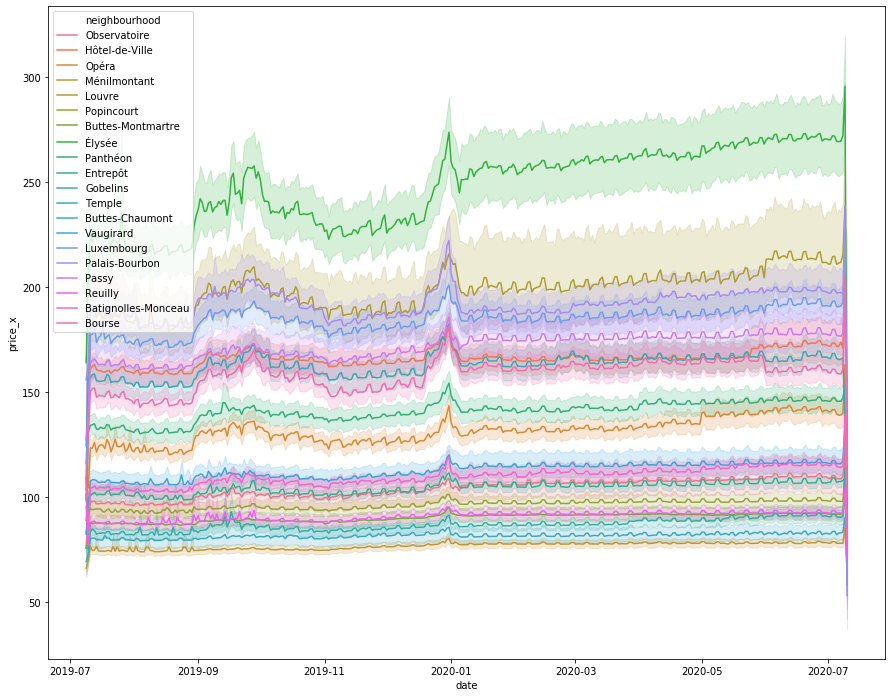

In [26]:
figure, axis = plt.subplots(1, 1, figsize=(15, 12))
sns.lineplot(x="date",y="price_x", hue="neighbourhood", data=df_merged)
plt.show()
# ça ne fait qu'augmenter à partir de janvier, de + en + cher à l'approche de l'été
# on observe des pics réguliers sur les courbes (hausse sur le WE chaque semaine => plotter plus fin pour vérifier)
# comprendre aussi ce que signifie la variance pastel sur les courbes


In [12]:
df_merged['available'] = df_merged['available'].map({'t':1, 'f': 0})

In [13]:
pouak = df_merged.groupby('neighbourhood').available.sum().reset_index()
pouak

,neighbourhood,available
0,Batignolles-Monceau,339379
1,Bourse,259993
2,Buttes-Chaumont,234733
3,Buttes-Montmartre,463663
4,Entrepôt,320254
5,Gobelins,159146
6,Hôtel-de-Ville,229248
7,Louvre,159516
8,Luxembourg,223946
9,Ménilmontant,235130


#### Number of listings that are unavailable per day

C:\Users\David\AppData\Local\Continuum\miniconda3\envs\udadsnd-p4\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


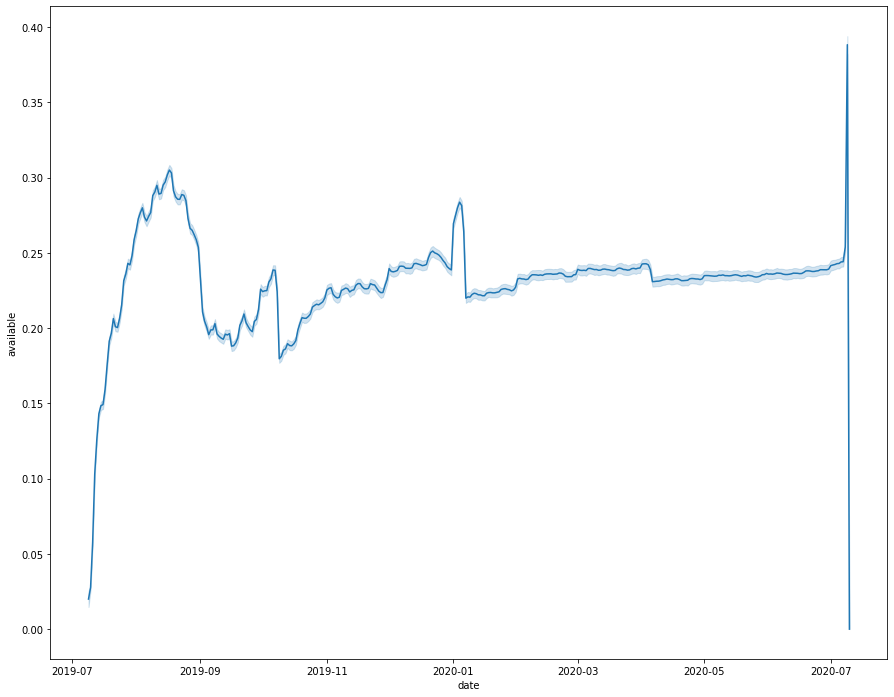

In [16]:
figure, axis = plt.subplots(1, 1, figsize=(15, 12))
sns.lineplot(x="date", y="available", data=df_merged[['date', 'available']])
plt.show()

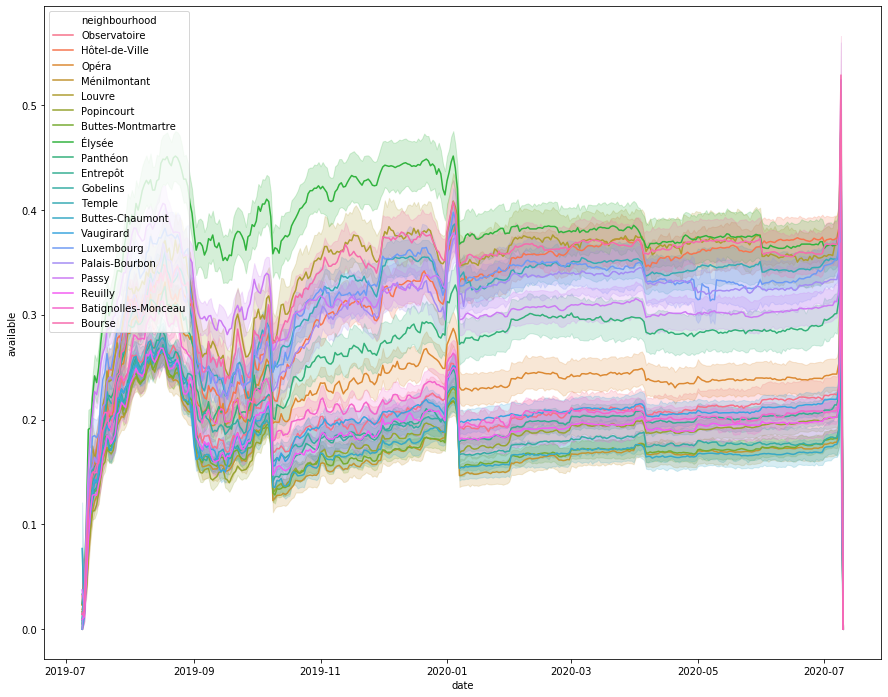

In [17]:
figure, axis = plt.subplots(1, 1, figsize=(15, 12))
sns.lineplot(x="date", y="available", hue="neighbourhood", data=df_merged[['date', 'available', 'neighbourhood']])
plt.show()

In [22]:
pouak['nb_list'] = df_lsts.groupby('neighbourhood').id.count().reset_index()['id']

In [24]:
pouak['availability'] = pouak.apply(lambda x: x['available']/x['nb_list'], axis=1)

In [26]:
pouak.sort_values(by='availability')

,neighbourhood,available,nb_list,availability
9,Ménilmontant,235130,3775,62.286093
3,Buttes-Montmartre,463663,7276,63.724986
2,Buttes-Chaumont,234733,3665,64.047203
15,Popincourt,425717,6311,67.456346
5,Gobelins,159146,2309,68.924210
16,Reuilly,187751,2655,70.716008
4,Entrepôt,320254,4464,71.741487
18,Vaugirard,356964,4782,74.647428
10,Observatoire,185738,2448,75.873366
0,Batignolles-Monceau,339379,4358,77.874943


In [10]:
df_merged.groupby('neighbourhood').available.mean().sort_values()

neighbourhood
Ménilmontant           0.170644
Buttes-Montmartre      0.174586
Buttes-Chaumont        0.175468
Popincourt             0.184807
Gobelins               0.188830
Reuilly                0.193739
Entrepôt               0.196547
Vaugirard              0.204510
Observatoire           0.207869
Batignolles-Monceau    0.213353
Opéra                  0.239145
Panthéon               0.271461
Palais-Bourbon         0.308025
Passy                  0.311597
Temple                 0.319091
Hôtel-de-Ville         0.321257
Luxembourg             0.321903
Bourse                 0.336467
Louvre                 0.343842
Élysée                 0.385548
Name: available, dtype: float64

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(15, 12))
sns.lineplot(x="date", y="available", hue="neighbourhood", data=df_merged)
plt.show()

C:\Users\David\AppData\Local\Continuum\miniconda3\envs\udadsnd-p4\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [13]:
df_lsts.groupby('neighbourhood').id.count().reset_index()

,neighbourhood,id
0,Batignolles-Monceau,4358
1,Bourse,2117
2,Buttes-Chaumont,3665
3,Buttes-Montmartre,7276
4,Entrepôt,4464
5,Gobelins,2309
6,Hôtel-de-Ville,1955
7,Louvre,1271
8,Luxembourg,1906
9,Ménilmontant,3775
